In [1]:
import numpy as np
import matplotlib.pyplot as plt

from latent_process import MaternProcess
from filtsmooth import KalmanFilter

In [2]:
#Creating sythetic data for y = sin(2*pi*t) + noise
tmin = 0
tmax = 4
num_data_pts = 100
grid = np.linspace(tmin, tmax, num_data_pts)
dt = float(grid[1]-grid[0])
obs = np.sin((2 * np.pi * grid)) + np.random.normal(loc=0, scale=0.5, size=len(grid)) 

#Introducing outliers
num_outliers = 10
start_idx = 5
idx = np.random.randint(start_idx, num_data_pts, size=num_outliers)
outliers = np.sin((2 * np.pi * grid[idx])) + np.random.normal(loc=0, scale=7, size=num_outliers)
obs[idx] = outliers

In [3]:
#latent process
n = 1 #dimension of f(t), the gaussian process
p = 2 #num_derivatives of f(t), or smoothness of Matern process
mp = MaternProcess(n=n, p=p, magnitude=3, lengthscale=0.3)
A = mp._A(dt)
Sigma = mp._Sigma(dt)
Sig0 = mp.Sig0

#observation process
output_dim = 1 if len(obs.shape)==1 else obs.shape[-1] 
H = np.concatenate([np.eye(n), np.zeros((n, n * p))], axis=1)
obs_noise = 0.1
R = obs_noise = np.eye(output_dim)

In [4]:
filter = KalmanFilter(obs=obs, A=A, Sigma=Sigma, H=H, R=R, Sig0=Sig0, weight_fct="")
filter_imq = KalmanFilter(obs=obs, A=A, Sigma=Sigma, H=H, R=R, Sig0=Sig0, weight_fct="IMQ")

In [5]:
m_filt_std, P_filt_std, m_std, P_std = filter.filtsmooth()
m_filt_imq, P_filt_imq, m_imq, P_imq = filter_imq.filtsmooth()

(0.0, 4.0)

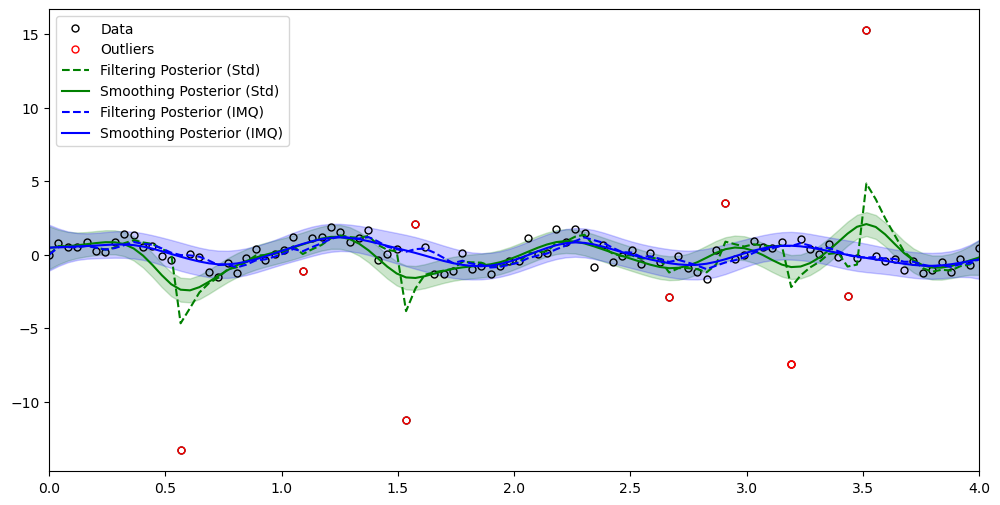

In [6]:
plt.figure(figsize=(12,6))

#plotting data points
plt.plot(grid, obs, 'o', markersize=5, color='black', fillstyle = 'none', label='Data')
plt.plot(grid[idx], obs[idx], 'o', markersize=5, color='red', fillstyle='none', label='Outliers')

#plotting standard Kalman Filter
color_std = 'green'
plt.plot(grid, m_filt_std[:, 0], '--', color = color_std, label='Filtering Posterior (Std)')
plt.plot(grid, m_std[:, 0], '-', color=color_std, label = 'Smoothing Posterior (Std)')
plt.fill_between(grid, m_std[:, 0] - 2 * np.sqrt(P_std[:, 0, 0]), m_std[:, 0] + 2 * np.sqrt(P_std[:, 0, 0]), alpha=0.2, color=color_std)

#plotting IMQ linear weighted Kalman Filter
color_imq = 'blue'
plt.plot(grid, m_filt_imq[:, 0], '--', color = color_imq, label='Filtering Posterior (IMQ)')
plt.plot(grid, m_imq[:, 0], '-', color=color_imq, label = 'Smoothing Posterior (IMQ)')
plt.fill_between(grid, m_imq[:, 0] - 2 * np.sqrt(P_imq[:, 0, 0]), m_imq[:, 0] + 2 * np.sqrt(P_imq[:, 0, 0]), alpha=0.2, color=color_imq)


plt.legend()
plt.xlim(tmin, tmax)